In [1]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from natsort import natsorted
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.cm as cm
from pygam import LinearGAM, s, f
import statsmodels.api as sm
from scipy import stats
import random
sns.set(font_scale=1.5, style="white")
random.seed(10)

In [2]:
df = pd.read_csv('../../Dataset/childhood/rna/brodmann_schaefer_0.5.csv')
df_copy = df.iloc[:200, 2:]
df.iloc[:200, 2:] = df.iloc[:200, 2:].values + df.iloc[200:, 2:].values
df.iloc[200:, 2:] = df_copy.values + df.iloc[200:, 2:].values

In [3]:
regionname = pd.read_csv('../../Dataset/childhood/atlas/schaefer400_regions.csv')
sarank = pd.read_csv('../../Dataset/childhood/saaxis/Sensorimotor_Association_Axis_AverageRanks.csv')
sarank = pd.concat([regionname.reset_index(drop=True), sarank.reset_index(drop=True)],axis=1)
sarank = sarank.loc[:, ['name', 'finalrank.wholebrain']]

In [4]:
adults = [ '18 yrs', '19 yrs', '21 yrs','23 yrs']
cbpd_wide = ['4 yrs', '8 yrs', '11 yrs','13 yrs']

In [5]:
brodregion = pd.read_csv('../../Dataset/childhood/rna/brodmann.csv')
saorder = pd.DataFrame([np.arange(11), ['Visual', 'Auditory', 'Sensory', 'Motor', 'IPC', 'STC', 'vPFC', 'dPFC', 'OFC', 'TEv', 'ACC']]).T
saorder.columns = ['sa', 'group']
#pd.merge(brodregion.iloc[:, :2], saorder, on='group', how='left').to_csv('../../Dataset/rna/brodmann.csv', index=False)

In [6]:
child_original = pd.read_csv('../../Derivatives/childhood/original_motion_1mm.csv')
adult_original = pd.read_csv('../../Derivatives/adult/original.csv')

In [7]:
Visual = [x for x in df.columns if 'BA17' in x]
Auditory = [x for x in df.columns if 'BA41' in x]
Sensory =  [x for x in df.columns if 'BA1_3' in x] + [x for x in df.columns if 'BA2' in x] # [x for x in sarank.name.values if 'S2' in x] +
Motor = [x for x in df.columns if 'BA4' in x]
vPFC = [x for x in df.columns if 'BA44' in x] +  [x for x in df.columns if 'BA45' in x]
dPFC = [x for x in df.columns if 'BA8' in x] + [x for x in df.columns if 'BA9' in x] + [x for x in df.columns if 'BA46' in x]
OFC = [x for x in df.columns if 'BA11' in x] + [x for x in df.columns if 'BA12' in x]+ [x for x in df.columns if 'BA13' in x]  + [x for x in df.columns if 'BA14_' in x]
TEv = [x for x in df.columns if 'BA20' in x]
ACC = [x for x in df.columns if 'BA24' in x] + [x for x in df.columns if 'BA25' in x] + [x for x in df.columns if 'BA32' in x]
STC = [x for x in df.columns if 'BA22' in x]
IPC = [x for x in df.columns if 'BA39' in x] +  [x for x in df.columns if 'BA40' in x]
child_regions = []
adult_regions = []
sas = []
for x in [Sensory, Auditory, Motor, Visual, vPFC, dPFC, OFC, TEv, ACC, STC, IPC]:
    print(x)
    roi  = df.loc[:, x].sum(axis=1)>0
    #if x == ['BA41_42_52']:
    #    roi[44] = True
    child_original['roi']=roi
    adult_original['roi']=roi
    child_regions.append(child_original[child_original.roi==True].mean()['H'])
    adult_regions.append(adult_original[adult_original.roi==True].mean()['H'])
    sas.append(child_original[child_original.roi==True].mean()['SArank'])

['BA1_3', 'BA2', 'BA20', 'BA21', 'BA22', 'BA23', 'BA24', 'BA25', 'BA26_29_30', 'BA27', 'BA28']
['BA41_42_52']
['BA4', 'BA40', 'BA41_42_52', 'BA43', 'BA44', 'BA45', 'BA46', 'BA47']
['BA17']
['BA44', 'BA45']
['BA8', 'BA9', 'BA46']
['BA11', 'BA13']
['BA20']
['BA24', 'BA25', 'BA32']
['BA22']
['BA39', 'BA40']


In [8]:
child = pd.DataFrame([['Sensory', 'Auditory', 'Motor', 'Visual', 'vPFC', 'dPFC', 'OFC', 'TEv', 'ACC', 'STC', 'IPC'], child_regions, sas]).T.sort_values(2).reset_index(drop=True)
child.columns = ['region', 'H', 'sa']
adult = pd.DataFrame([['Sensory', 'Auditory', 'Motor', 'Visual', 'vPFC', 'dPFC', 'OFC', 'TEv', 'ACC', 'STC', 'IPC'], adult_regions, sas]).T.sort_values(2).reset_index(drop=True)
adult.columns = ['region', 'H', 'sa']

In [9]:
gene_columns = pd.read_csv('all_genes.csv')

In [10]:
stronger = pd.read_csv('combine.csv')

In [11]:
stronger[stronger.rsquare_x>0.425789][stronger.rsquare_y>0.359704]

<ipython-input-11-606ac5a4f57f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  stronger[stronger.rsquare_x>0.425789][stronger.rsquare_y>0.359704]


,gene,coef_x,pvalue_x,rsquare_x,coef_y,pvalue_y,rsquare_y
4,FNDC4,0.113561,0.007160,0.523183,0.070392,0.006957,0.526032
8,PIM3,0.174791,0.008777,0.502473,0.074760,0.001684,0.649009
9,F10,0.218763,0.008881,0.501253,0.105948,0.008142,0.510202
12,SNX21,0.249518,0.010308,0.485563,0.107217,0.017448,0.426604
13,UBE2QL1,0.139778,0.012674,0.463075,0.068132,0.028627,0.365977
14,SEZ6L2,0.136026,0.012772,0.462225,0.035201,0.018522,0.419558
15,RXRB,0.227460,0.014257,0.449888,0.111058,0.002531,0.617136
16,IL32,0.263702,0.016033,0.436456,0.082932,0.029165,0.363598
17,PVALB,0.024710,0.017570,0.425789,0.018409,0.030064,0.359704


In [12]:
selected = gene_columns.loc[:, list(stronger.gene.values)+['sa', 'donor_id', 'age']]

In [13]:
alls = []
a = np.arange(11)
for i in np.arange(1000):
    if i%50==0:
        print(i)
    a = np.random.permutation(a)
    age = adults
    wide = selected.loc[[x for x in selected.index if selected.loc[x,'age'] in age], :]
    wide = wide[wide.sa>-1].sort_values('sa')
    wide = wide.loc[:, ['sa', 'donor_id']+list(selected.columns[:-3])].groupby(['sa', 'donor_id']).median().reset_index()
    wide = pd.merge(wide, selected.loc[:, ['donor_id', 'age']], on='donor_id')    
    wide_age = wide.loc[[x for x in wide.index if wide.loc[x,'age'] in age], :]
    wide_mean = wide_age.iloc[:, :-1].groupby(['sa']).median().reset_index()
    wide_mean = wide_mean.apply(lambda x: [x[t] for t in a])
    coef = []
    pvalue = []
    rsquare = []
    for marker in enumerate(selected.columns[:-3]):
        marker = marker[1]
        X = sm.add_constant(wide_mean[marker].values)
        results = sm.OLS([float(x) for x in adult['H'].values], X).fit()
        coef.append(results.params[1])
        pvalue.append(results.pvalues[1])
        rsquare.append(results.rsquared_adj)
    df_adult = pd.DataFrame([selected.columns[:-3], coef, pvalue, rsquare]).T
    df_adult.columns = ['gene', 'coef', 'pvalue','rsquare']
    #df_adult = df_adult[df_adult.coef>0][df_adult.pvalue<0.05].sort_values('pvalue').reset_index(drop=True)
    age = cbpd_wide
    wide = selected.loc[[x for x in selected.index if selected.loc[x,'age'] in age], :]
    wide = wide[wide.sa>-1].sort_values('sa')
    wide = wide.loc[:, ['sa', 'donor_id']+list(selected.columns[:-3])].groupby(['sa', 'donor_id']).median().reset_index()
    wide = pd.merge(wide, selected.loc[:, ['donor_id', 'age']], on='donor_id')    
    wide_age = wide.loc[[x for x in wide.index if wide.loc[x,'age'] in age], :]
    wide_mean = wide_age.iloc[:, :-1].groupby(['sa']).median().reset_index()
    wide_mean = wide_mean.apply(lambda x: [x[t] for t in a])
    coef = []
    pvalue = []
    rsquare = []
    for marker in enumerate(selected.columns[:-3]):
        marker = marker[1]
        X = sm.add_constant(wide_mean[marker].values)
        results = sm.OLS([float(x) for x in child['H'].values], X).fit()
        coef.append(results.params[1])
        pvalue.append(results.pvalues[1])
        rsquare.append(results.rsquared_adj)
    df_child = pd.DataFrame([selected.columns[:-3], coef, pvalue, rsquare]).T
    df_child.columns = ['gene', 'coef', 'pvalue','rsquare']
    #df_child = df_child[df_child.coef>0][df_child.pvalue<0.05].sort_values('pvalue').reset_index(drop=True)
    df_combine = pd.merge(df_adult, df_child, on='gene', how='inner')
    PV_adult =df_combine[df_combine.gene=='PVALB'].rsquare_x.values[0]  #0.425789#
    PV_child = df_combine[df_combine.gene=='PVALB'].rsquare_y.values[0] #0.359704  #
    alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
    print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])

0
7


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

34
10
3


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


0
9


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

1
35
11
29
11


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

13
2
12
11
7


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

1
3
2


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

11
7
15
16
20


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

0
18
6
27


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

1
0
22
7
2

<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

36
13
0


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

11
1
18


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

22
3
22
5


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

3
27
20


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

0
5
7
1
50


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


12
4


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

21
19
1


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

12
14
10


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

4
9
4
14


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


2
0
5
12
3


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

12
19
8


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

17
3


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

1
18
17


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

8
6
17
27


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

13
5
34
8
8


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

0
31


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

21
34
4
0
3


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

25
33
7
13


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

1
13
25
5
2
100
15


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

9
3
1
1


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

40
12
24
19


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

26
25
6
16
7
16
29
16
0


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

5
28
8
3


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

16
1
11


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


21
9
23


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

9
13
4
11
2
5


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

15
13
27
2
2


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

3
17
30
3


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

1
19
8
10
0


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

30
3
150
25


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

5
20
11


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

3


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


31
19


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


10
14
22
12


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

5
33
2
3
31
29
6
3


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

7
13
14


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

27
2
5
10
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

15
19
2
15


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

7
3
36
13


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

4
19
14
13
4
10


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

14
17
27
5
22
4
12
6


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

6
200
21
14
9
1
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

3
4
13


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

1
3
3
15


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

9
22
26


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

15
5
5
18
1


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

1
9
16
3
4


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

9
8
9


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

10
25
33


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

28
4
12
1
23
2
1


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

12
35
10


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

2
13
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

5
19
26


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

16
7
20
250
30


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

0
1
18
5


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

15
7
4
3
7
35
12


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

6
7
13
11
20


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

24
17
19
13


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

0
1


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

16
1
14
2
6
3
9


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

25
19
1
20
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

13
0
24


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

27
2
2


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

15
2
9


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

10
6
2
0
26


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

27
300
7
0
7
3
1
8


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

6
25
32


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

5
8
8
8
3
22
5


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

13
1
8
32
4
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

30
13
5
0
19


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

34
17
3


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

24
12
0
18

<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi


16
7
1
21
8
3


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

3
2
1
1
14
11


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

4
2
31
17
350


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

1
4
29
29
11


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

19
30
28
13


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

15
9
14
14
20


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

2
1
8


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

0
18
0
0
21
15
24


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

12
1
5
9
4
2
7
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

4
6
16
1
3


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

3
2
1


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

25
36
17
5
23


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

13
22
13
0


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

2
400
10
17
14


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

37
7
30


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

12
18
3
12


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

1
0
0
2


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

8
16
9
7


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

7
20
7


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

28
24
2
3


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

7
16
16
0
16


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

19
7
8
1


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

24
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

0
16
6


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

2
14


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

14
7
7
16
4


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

29
20
0


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

1
450
1
4
20
10
25
4
5
1
6

<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi


2
22
10
4


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

22
16


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

0
0


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


2
2
20


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

2
27
3


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

0
11
4


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

15
33
17


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

30
1
14


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

21
10


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


13
0
25


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

4
2
6


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

22
5
30
13
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

1
13
24
2


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

24
500
17


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

34
11


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

6
4
11
5
18


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

8
15
5


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


1
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

1
3
6
14


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

4
3
3


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

30
23
4
10


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

19
11
5


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

11
11
21


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


1
9


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

9
11


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

10
6
4
17
18


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

2
5


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

15
4
17
32
2


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

0
6
6
10
550
25


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

20
13
11
3


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


3
18


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

14
2
11
16
12


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

0
12
9


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

13
6
0
4
20


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


18
8


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

8
30
0


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


10
3
7


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

36
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

14
7


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

24
21
6


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


3
13
10
19


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

2
18
13
35


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

18
9


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

12
4
11


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

9
13
600
18


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

26
30


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

6
24
2
9


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

5
1
2
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

0
33
2
1


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

0
0
13


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

0
31
11
12
7
1


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

19
4
6
15


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

0
0
15


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

4
7
23
4
23


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

4
12
15


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

0
19


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

1
11
1
29


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


9
1


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

10
0
13
650
10


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

1
14
11
3


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

15
2
2


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


2
6


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

3
31
8
25


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

12
2
2
8
7
26
0
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

21
7
1
6
5


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

5
22
18
7
0
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

20
18
13
6


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

0
10
2


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


25
19
0
29


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

10
8
4
12
6


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

5
700
1
4
7
28


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

19
13
5
0
29


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

1
10
6
1
13
1


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

1
1
29
10
4
0


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

18
29
6
23
0
10


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

1
2
7
19
8


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

15
5
25
28


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

2
11


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

24
0
3
16
35
0


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

1
10
26
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

4
14
750
0
24


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

10
5
19
2
35


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

8
3
4
7
4


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

15
3
10
11
1
3
26
24


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

11
1
8
17
1
5
14


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

7
6


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


24
17
1


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

3
8
4


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

1
11
8


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

9
34
1
6
17


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

4
26


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

28
14
17
8
11
800


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

20
10
9
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

15
25
7
1


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

16
12
0
1


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


5
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

2
3
35


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


24
2
20


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

17
2
4


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


15
16


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

32
24
3


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

11
12
0
6
17
6


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

32
4
10
31


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

1
5
5
17
18


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

5
0
24
4


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

0
32


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

0
850
0
11
2
5


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

9
0
6


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

17
3


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

9
11
9
9
7
3


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

7
3
3


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

0
11
3


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


0
17
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

7
25
14
12
0
29


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

27
4
1
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

3
21
28
7
19
4


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

11
2
3
2
10
10


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

0
5
18
2
900
16


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

6
5
7
25


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

17
3
4
40
2


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

14
0
7
6
1


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

20
0
17
3
32


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


23
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

15
15
3


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

0
0
31
0
3
12
21
4


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

21
22
8
1
15
12
9


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

23
1
37
14
16


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

14
17
25
12
0
950


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

7
6
32
4
15


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

5
3
26


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

7
15
5
5
6


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

4
2
14


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])


2
1


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

19
33
23


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

8
20
6


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

21
3
11
2
32


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

2
13


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

29
21
0
23


<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsq

34
4
11
0
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

5
16
16
0


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

7
11
5
28
9
6


<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df_combine[df_combine.rsquare_x>PV_adult][df_combine.rsquare_y>PV_child].shape[0])
<ipython-input-13-fc7ab27f773a>:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  alls.append(df_combine[df_combine.rsquare_x>PV_adult][df_combi

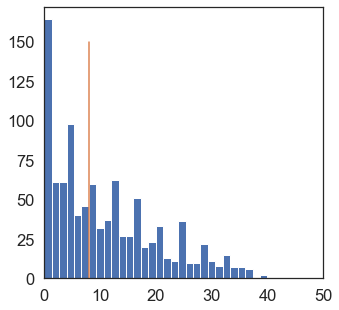

In [14]:
figure = plt.figure(figsize=(5,5))
plt.hist(alls, bins=30)
plt.plot([8,8], [0,150])
plt.xlim([0, 50])
plt.savefig('permutation_PV.eps')

In [15]:
len([x for x in alls if x >= 8]) / 1000

0.53